In [1]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import pandas as pd
import numpy as np
from time import perf_counter 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import sem
import pickle
%matplotlib inline

testeid = 8 # EDIT TESTEID

In [2]:
np.random.seed(0)
tf.random.set_seed(0)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

path2cv='/home/jreynolds/21summer/epidural/ct_cv_models/'
model_dir = 'A/'
subdir = '2/'
version = 'S'+str(testeid)+'/' # EDIT VERSION
if testeid in [6, 7, 8]:
    this_import_path = path2cv+model_dir+version
else:
    this_import_path = path2cv+model_dir+subdir
print(f'\ntesteid: %d' %testeid)
print(f'path:    %s' %str(this_import_path))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

testeid: 8
path:    /home/jreynolds/21summer/epidural/ct_cv_models/A/S8/


# Import results

In [3]:
# filenames
infile1 = 'S'+str(testeid)+'_y_preds_InceptionV3'
infile2 = 'S'+str(testeid)+'_y_test_InceptionV3'
infile3 = 'S'+str(testeid)+'_X_test_InceptionV3'
infile4 = 'S'+str(testeid)+'_trainhist_InceptionV3'
infile5 = 'S'+str(testeid)+'_times_InceptionV3'
infile6 = 'S'+str(testeid)+'_testEval_InceptionV3'
# import y_preds
f = open(this_import_path+infile1,'rb')
y_preds_raw = pickle.load(f)
f.close()

# import y_test
f = open(this_import_path+infile2,'rb')
y_test_raw = pickle.load(f)
f.close()

# import X_test
f = open(this_import_path+infile3,'rb')
X_test = pickle.load(f)
f.close()

# import training history
f = open(this_import_path+infile4,'rb')
trainhist = pickle.load(f)
f.close()

# import times
f = open(this_import_path+infile5,'rb')
times = pickle.load(f)
f.close()

# import test evaluation
f = open(this_import_path+infile6,'rb')
testeval = pickle.load(f)
f.close()

print("imported files summary")
print("filename | length | shape")
print(infile1, " |", len(y_preds_raw), " |", y_preds_raw.shape, " |", type(y_preds_raw) )
print(infile2, " |", len(y_test_raw), " |", y_test_raw.shape, " |", type(y_test_raw) )
print(infile3, " |", len(X_test), " |", X_test.shape, " |", type(X_test) )
#print(infile4, " |", len(trainhist), " |", trainhist, " |", type(trainhist) )
print("\n")
y_preds = [i[0] for i in y_preds_raw] # convert to list
y_test = [i for i in y_test_raw] # convert to list
predtest_dict={'y_preds':y_preds,'y_test':y_test}
df0=pd.DataFrame(predtest_dict)
df0
#df0.to_csv(r'/home/jreynolds/21summer/epidural/ct_cv_models/y_preds_y_test.csv')

imported files summary
filename | length | shape
S8_y_preds_InceptionV3  | 3000  | (3000, 1)  | <class 'numpy.ndarray'>
S8_y_test_InceptionV3  | 3000  | (3000,)  | <class 'numpy.ndarray'>
S8_X_test_InceptionV3  | 3000  | (3000, 681, 241, 1)  | <class 'numpy.ndarray'>




,y_preds,y_test
0,1964.666748,1981.25
1,2102.573975,2125.00
2,2066.459961,2025.00
3,2554.836426,2550.00
4,1902.746338,1793.75
...,...,...
2995,2641.748779,2643.75
2996,2489.275146,2512.50
2997,2654.059814,2631.25
2998,2352.500732,2356.25


In [4]:
print("MINIMUM true dist for subject "+str(testeid)+" is "+str(min(df0['y_test'])))
print("MAXIMUM true dist for subject "+str(testeid)+" is "+str(max(df0['y_test'])))
#min_dist = min(df0['y_test'])
#max_dist = max(df0['y_test'])

MINIMUM true dist for subject 8 is 100.0
MAXIMUM true dist for subject 8 is 3506.25


In [5]:
n_bins=5
upper=3000
lower=100

r=upper-lower
binsize=r/n_bins

upperLimits={}
upperLimits[0]=lower+binsize
upperLimits[1]=upperLimits[0]+binsize
upperLimits[2]=upperLimits[1]+binsize
upperLimits[3]=upperLimits[2]+binsize
upperLimits[4]=upperLimits[3]+binsize

lowerLimits={}
lowerLimits[0]=lower
lowerLimits[1]=lowerLimits[0]+binsize
lowerLimits[2]=lowerLimits[1]+binsize
lowerLimits[3]=lowerLimits[2]+binsize
lowerLimits[4]=lowerLimits[3]+binsize

print("Lower limits:\n", lowerLimits)
print("Upper limits:\n", upperLimits)

Lower limits:
 {0: 100, 1: 680.0, 2: 1260.0, 3: 1840.0, 4: 2420.0}
Upper limits:
 {0: 680.0, 1: 1260.0, 2: 1840.0, 3: 2420.0, 4: 3000.0}


In [6]:
df1=df0.sort_values('y_test')
df1=df1.reset_index(drop=True)
#dfc=df1.copy()
df1['mape']=100*(abs(df1.y_test-df1.y_preds)/df1.y_test)
df1['mae']=abs(df1.y_test-df1.y_preds)
dfc=df1.copy()
df1

,y_preds,y_test,mape,mae
0,277.140594,100.00,177.140594,177.140594
1,193.831726,106.25,82.429860,87.581726
2,196.705124,106.25,85.134234,90.455124
3,206.220276,112.50,83.306912,93.720276
4,215.560226,112.50,91.609090,103.060226
...,...,...,...,...
2995,2923.456787,3493.75,16.323240,570.293213
2996,2731.512451,3493.75,21.817175,762.237549
2997,2966.800293,3500.00,15.234277,533.199707
2998,2950.466797,3506.25,15.851214,555.783203


In [7]:
dfX=dfc.copy()
#dfX.insert(4, "bin", -1)
bin_series=pd.Series([])
for i in range(len(df1['y_test'])):
    #if (df1['y_test'][i] >= lowerLimits[0]) and (df1['y_test'][i] <= upperLimits[0]):
    if (df1['y_test'][i] <= upperLimits[0]):
        bin_series[i]=0
    elif (df1['y_test'][i] > lowerLimits[1]) and (df1['y_test'][i] <= upperLimits[1]):
        bin_series[i]=1
    elif (df1['y_test'][i] > lowerLimits[2]) and (df1['y_test'][i] <= upperLimits[2]):
        bin_series[i]=2
    elif (df1['y_test'][i] > lowerLimits[3]) and (df1['y_test'][i] <= upperLimits[3]):
        bin_series[i]=3
    #elif (df1['y_test'][i] > lowerLimits[4]) and (df1['y_test'][i] <= upperLimits[4]):
    elif (df1['y_test'][i] > lowerLimits[4]):
        bin_series[i]=4

# insert series object into dataframe
dfX.insert(len(dfX.columns), "bin", bin_series)
dfX

<ipython-input-7-e73d51313dd0>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bin_series=pd.Series([])


,y_preds,y_test,mape,mae,bin
0,277.140594,100.00,177.140594,177.140594,0
1,193.831726,106.25,82.429860,87.581726,0
2,196.705124,106.25,85.134234,90.455124,0
3,206.220276,112.50,83.306912,93.720276,0
4,215.560226,112.50,91.609090,103.060226,0
...,...,...,...,...,...
2995,2923.456787,3493.75,16.323240,570.293213,4
2996,2731.512451,3493.75,21.817175,762.237549,4
2997,2966.800293,3500.00,15.234277,533.199707,4
2998,2950.466797,3506.25,15.851214,555.783203,4


In [8]:
dfb0=dfX.loc[dfX['bin'] == 0]
dfb1=dfX.loc[dfX['bin'] == 1]
dfb2=dfX.loc[dfX['bin'] == 2]
dfb3=dfX.loc[dfX['bin'] == 3]
dfb4=dfX.loc[dfX['bin'] == 4]

# Violin Plots

### Relative Error (absolute percentage error)

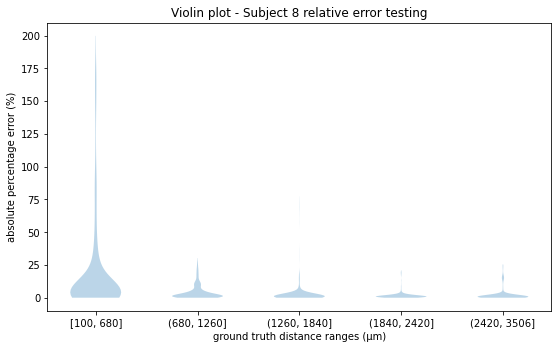

In [14]:
b0_list=dfb0['mape']
b1_list=dfb1['mape']
b2_list=dfb2['mape']
b3_list=dfb3['mape']
b4_list=dfb4['mape']
data = [b0_list, b1_list, b2_list, b3_list, b4_list]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
vp = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
ax.set_title('Violin plot - Subject '+str(testeid)+' relative error testing')
ax.set_ylabel('absolute percentage error (%)')
ax.set_xlabel('ground truth distance ranges (µm)')
ticks=[
    "["+str(lowerLimits[0])+", "+str(int(upperLimits[0]))+"]", 
    "("+str(int(lowerLimits[1]))+", "+str(int(upperLimits[1]))+"]", 
    "("+str(int(lowerLimits[2]))+", "+str(int(upperLimits[2]))+"]", 
    "("+str(int(lowerLimits[3]))+", "+str(int(upperLimits[3]))+"]", 
    #"("+str(lowerLimits[4]+0.1)
    "("+str(int(lowerLimits[4]))+", "+str(int(max(dfX['y_test'])))+"]"
]
ax.set_xticks(np.arange(1, len(data) + 1))
ax.set_xticklabels(ticks)
#ax.set_ylim([0, max(dfX['mape'])+5])
#ax.set_ylim([0, 25])
exportpath='/home/jreynolds/21summer/epidural/PostProc/'
plt.savefig(exportpath+"vp_s"+str(testeid)+"_relerr.svg", dpi=300, bbox_inches='tight')
plt.show()

### Absolute Error

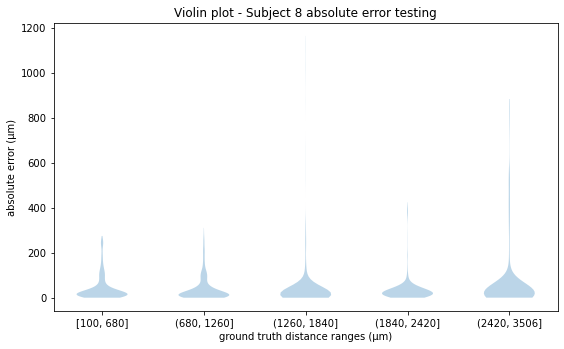

In [10]:
b0_list=dfb0['mae']
b1_list=dfb1['mae']
b2_list=dfb2['mae']
b3_list=dfb3['mae']
b4_list=dfb4['mae']
data = [b0_list, b1_list, b2_list, b3_list, b4_list]
fig = plt.figure(figsize =(7, 4))
ax = fig.add_axes([0, 0, 1, 1])
vp = ax.violinplot(data, showmeans=False, showmedians=False, vert=True, showextrema=False)
ax.set_title('Violin plot - Subject '+str(testeid)+' absolute error testing')
ax.set_ylabel('absolute error (µm)')
ax.set_xlabel('ground truth distance ranges (µm)')
ticks=[
    "["+str(lowerLimits[0])+", "+str(int(upperLimits[0]))+"]", 
    "("+str(int(lowerLimits[1]))+", "+str(int(upperLimits[1]))+"]", 
    "("+str(int(lowerLimits[2]))+", "+str(int(upperLimits[2]))+"]", 
    "("+str(int(lowerLimits[3]))+", "+str(int(upperLimits[3]))+"]", 
    #"("+str(lowerLimits[4]+0.1)
    "("+str(int(lowerLimits[4]))+", "+str(int(max(dfX['y_test'])))+"]"
]
ax.set_xticks(np.arange(1, len(data) + 1))
ax.set_xticklabels(ticks)
exportpath='/home/jreynolds/21summer/epidural/PostProc/'
plt.savefig(exportpath+"vp_s"+str(testeid)+"_abserr.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Check Integrity and Display Summary

In [11]:
if (len(dfb0)+len(dfb1)+len(dfb2)+len(dfb3)+len(dfb4) != 3000):
    bad_n=len(dfb0)+len(dfb1)+len(dfb2)+len(dfb3)+len(dfb4)
    print("\n\n!!!!!! ERROR - "+str(bad_n)+" images were binned, should have 3000")
else:
    print("\nSuccess - All "+str(len(dfb0)+len(dfb1)+len(dfb2)+len(dfb3)+len(dfb4))+" images considered")
    
n_images=len(dfb0)+len(dfb1)+len(dfb2)+len(dfb3)+len(dfb4)
bin_sizes=[len(dfb0), len(dfb1), len(dfb2), len(dfb3), len(dfb4)]
print("\n--- Summary ---")
print("Test subject:                  "+str(testeid))
print("Number of images considered:   "+str(n_images))
print("Number of images per bin:     ", bin_sizes)
print("Minimum ground truth distance: "+str(min(dfX['y_test'])) )
print("Maximum ground truth distance: "+str(max(dfX['y_test'])) )
print("Average relative error:        "+str(sum(dfX['mape']/len(dfX['mape']))) )
print("Best relative error:           "+str(min(dfX['mape'])) )
print("Worst relative error:          "+str(max(dfX['mape'])) )
print("Average absolute error:        "+str(sum(dfX['mae']/len(dfX['mae']))))
print("Best absolute error:           "+str(min(dfX['mae'])) )
print("Worst absolute error:          "+str(max(dfX['mae'])) )


Success - All 3000 images considered

--- Summary ---
Test subject:                  8
Number of images considered:   3000
Number of images per bin:      [777, 509, 696, 570, 448]
Minimum ground truth distance: 100.0
Maximum ground truth distance: 3506.25
Average relative error:        6.728516481887461
Best relative error:           0.0009964923469387755
Worst relative error:          199.744873046875
Average absolute error:        42.61485943094887
Best absolute error:           0.0152587890625
Worst absolute error:          1164.340087890625


# Box Plot
- Sort dataframe based on ground truth values in increasing order
- Partition dataframe -- range=100-3000

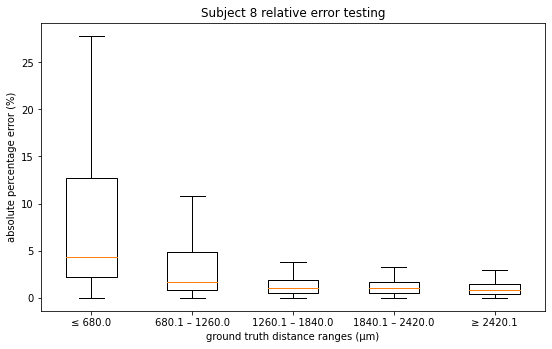

In [12]:
b0_list=dfb0['mape']
b1_list=dfb1['mape']
b2_list=dfb2['mape']
b3_list=dfb3['mape']
b4_list=dfb4['mape']

#print('bin 1')
#print('len:', len(b1_list))

data = [b0_list, b1_list, b2_list, b3_list, b4_list]
#fig = plt.figure(figsize =(7, 4))

fig = plt.figure(figsize =(7, 4))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# x-axis: ground truth distances
# y-axis: MAPE (%)
# orange is mean
# box is std dev
# whiskers are quartiles
ax.set_title('Subject '+str(testeid)+' relative error testing')
ax.set_ylabel('absolute percentage error (%)')
ax.set_xlabel('ground truth distance ranges (µm)')
ticks=["≤ "+str(upperLimits[0]-0.0), 
       #str(lowerLimits[0]+0.1)+" – "+str(upperLimits[0]-0.0), 
       str(lowerLimits[1]+0.1)+" – "+str(upperLimits[1]-0.0), 
       str(lowerLimits[2]+0.1)+" – "+str(upperLimits[2]-0.0), 
       str(lowerLimits[3]+0.1)+" – "+str(upperLimits[3]-0.0), 
       "≥ "+str(lowerLimits[4]+0.1)
       #str(lowerLimits[4]+0.1)+" – "+str(upperLimits[4]-0.0)
      ]
ax.set_xticklabels(ticks)
plt.show()

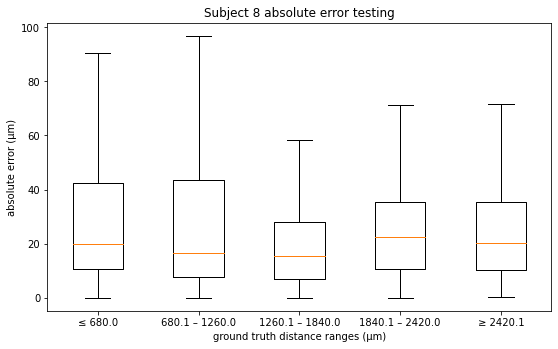

In [13]:
b0_list=dfb0['mae']
b1_list=dfb1['mae']
b2_list=dfb2['mae']
b3_list=dfb3['mae']
b4_list=dfb4['mae']

#print('bin 1')
#print('len:', len(b1_list))

data = [b0_list, b1_list, b2_list, b3_list, b4_list]
fig = plt.figure(figsize =(7, 4))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data, showfliers=False)
# x-axis: ground truth distances
# y-axis: MAPE (%)
# orange is mean
# box is std dev
# whiskers are quartiles
#ax.legend(['bin 1: dist <  µm', 'bin 2: dist '])
ax.set_title('Subject '+str(testeid)+' absolute error testing')
ax.set_ylabel('absolute error (µm)')
ax.set_xlabel('ground truth distance ranges (µm)')
ticks=["≤ "+str(upperLimits[0]-0.0), 
       #str(lowerLimits[0]+0.1)+" – "+str(upperLimits[0]-0.0), 
       str(lowerLimits[1]+0.1)+" – "+str(upperLimits[1]-0.0), 
       str(lowerLimits[2]+0.1)+" – "+str(upperLimits[2]-0.0), 
       str(lowerLimits[3]+0.1)+" – "+str(upperLimits[3]-0.0), 
       "≥ "+str(lowerLimits[4]+0.1)
       #str(lowerLimits[4]+0.1)+" – "+str(upperLimits[4]-0.0)
      ]
#print(ticks)
ax.set_xticklabels(ticks)
# show plot
plt.show()